In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv("/content/heart_disease_uci.csv")
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [2]:
df.info()
df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,920.0,NaN,NaN,NaN,460.5,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,NaN,NaN,NaN,53.51087,9.424685,28.0,47.0,54.0,60.0,77.0
sex,920,2,Male,726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dataset,920,4,Cleveland,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cp,920,4,asymptomatic,496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,861.0,NaN,NaN,NaN,132.132404,19.06607,0.0,120.0,130.0,140.0,200.0
chol,890.0,NaN,NaN,NaN,199.130337,110.78081,0.0,175.0,223.0,268.0,603.0
fbs,830,2,False,692,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restecg,918,3,normal,551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thalch,865.0,NaN,NaN,NaN,137.545665,25.926276,60.0,120.0,140.0,157.0,202.0


In [3]:
df.isnull().sum()
df['num'].unique()

array([0, 2, 1, 3, 4])

In [4]:
df.select_dtypes(include='object').columns

Index(['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object')

In [5]:
# Data cleaning

#1 convert Booleanlike columns to int(0/1)
bools_cols=['fbs', 'exang']
for col in bools_cols:
  # Map True to 1, False to 0, and then fill any remaining NaNs (original NaNs) with 0
  df[col]=df[col].map({True: 1, False: 0}).fillna(0).astype(int)
df[bools_cols].head()

# Sex column change into encoded
df['sex']=df['sex'].map({'Male':1, 'Female':0})

In [6]:
#2 Missing Values
df.isna().sum()

# Median Imputation Numerical
num_cols=df.select_dtypes(include=['float64','int64']).columns.tolist()
from sklearn.impute import SimpleImputer
median_imputer=SimpleImputer(strategy='median')
df[num_cols]=median_imputer.fit_transform(df[num_cols])

# Mode Imputation Categorical
cat_cols=df.select_dtypes(include='object').columns.tolist()
mode_imputer=SimpleImputer(strategy='most_frequent')
df[cat_cols]=mode_imputer.fit_transform(df[cat_cols])

In [7]:
#3 Duplicate
before=df.shape
df=df.drop_duplicates()
after=df.shape
before, after

((920, 16), (920, 16))

In [8]:
#4 Outlier Handling(IQR Method) only for Numerical columns
import numpy as np
numeric_cols=['age','trestbps','chol','thalch','oldpeak']

def remove_outliers(data,col):
  Q1=data[col].quantile(0.25)
  Q3=data[col].quantile(0.75)
  IQR=Q3-Q1
  low=Q1-1.5*IQR
  high=Q3+1.5*IQR
  return data[(data[col]>=low)&(data[col]<=high)]
for col in numeric_cols:
  df=remove_outliers(df,col)


In [9]:
df['num']=df['num'].apply(lambda x: 1 if x>0 else 0)
df['num'].value_counts()

,count
num,
0,378
1,324


In [10]:
df.shape
#df.info()

(702, 16)

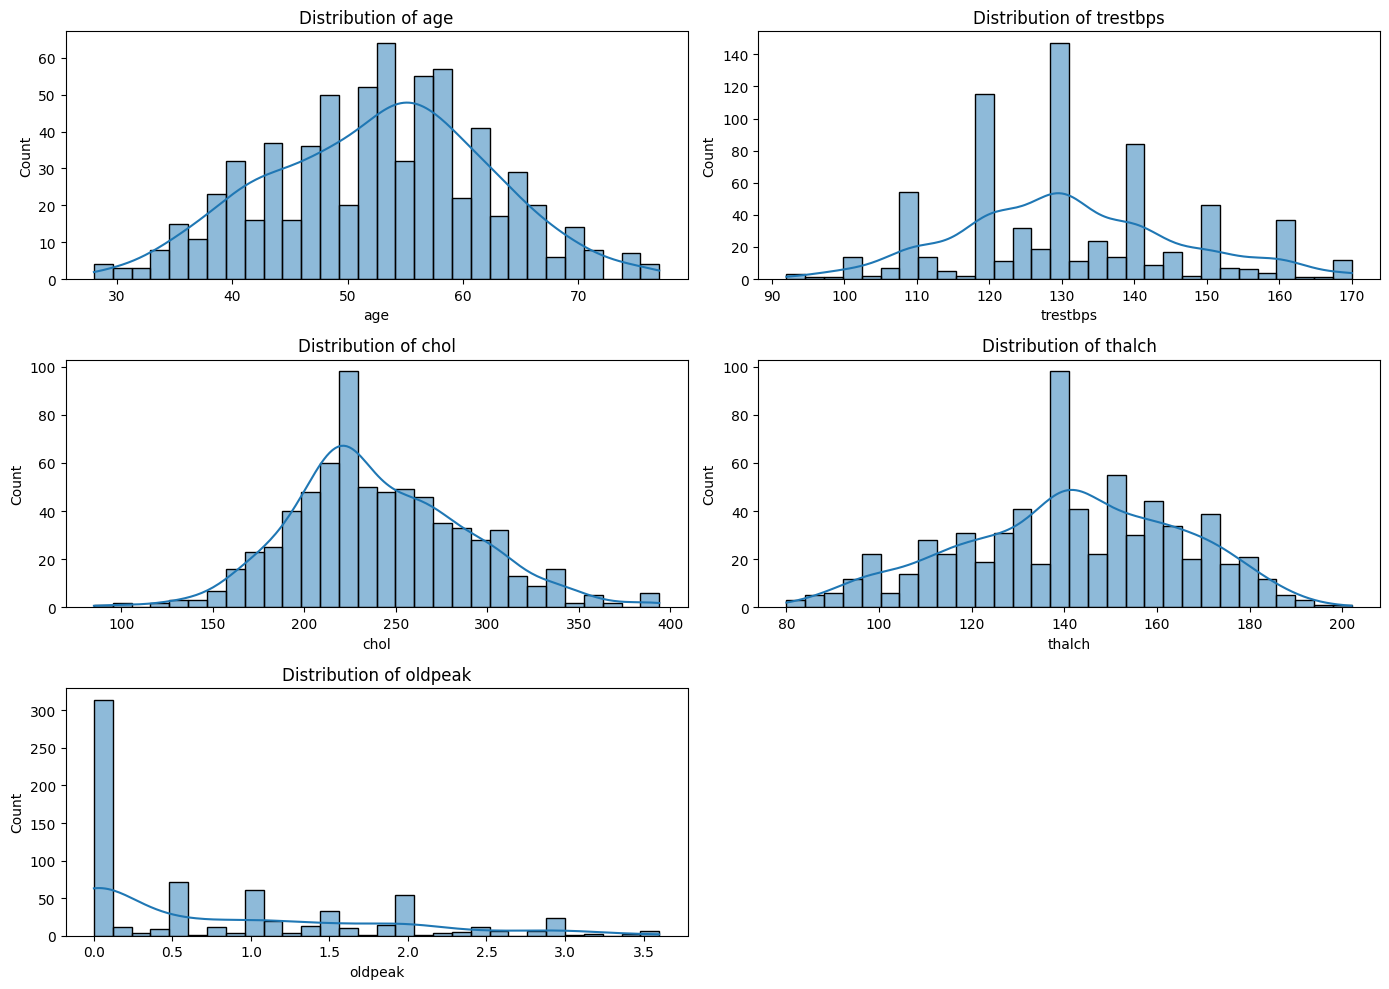

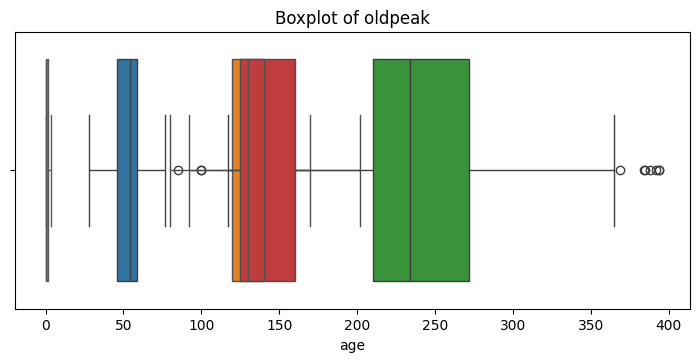

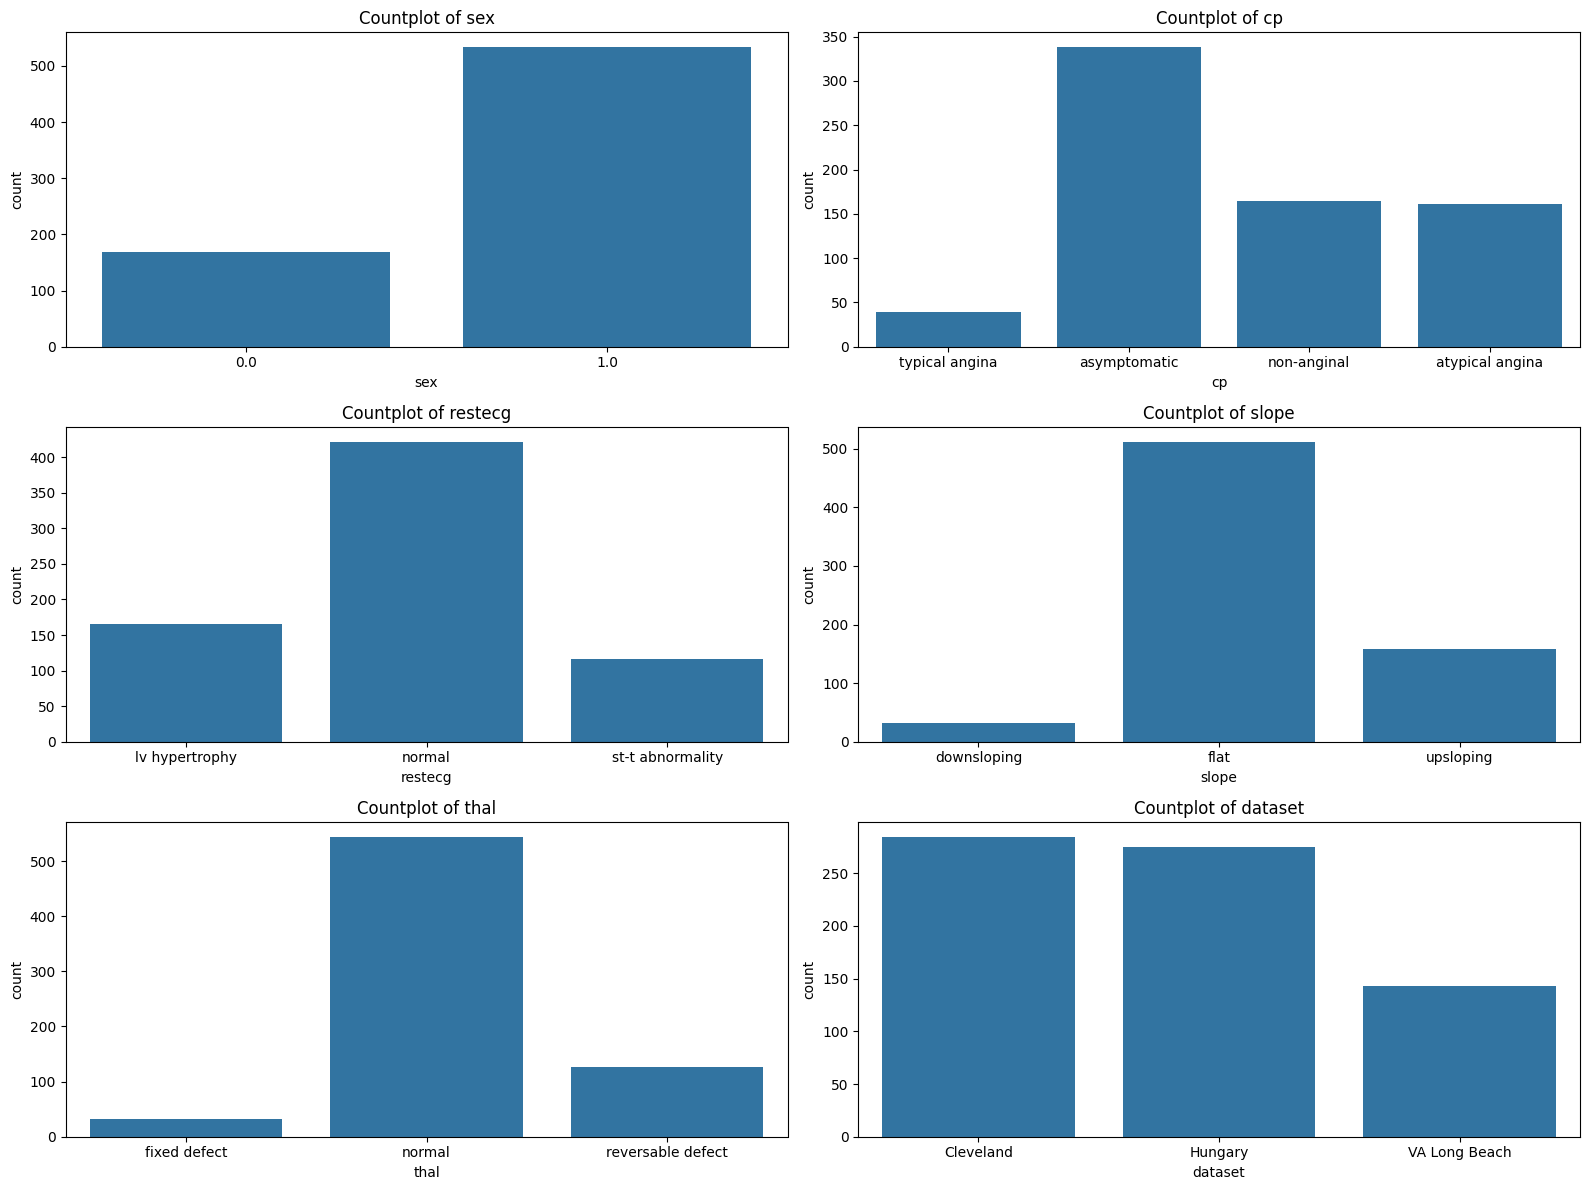

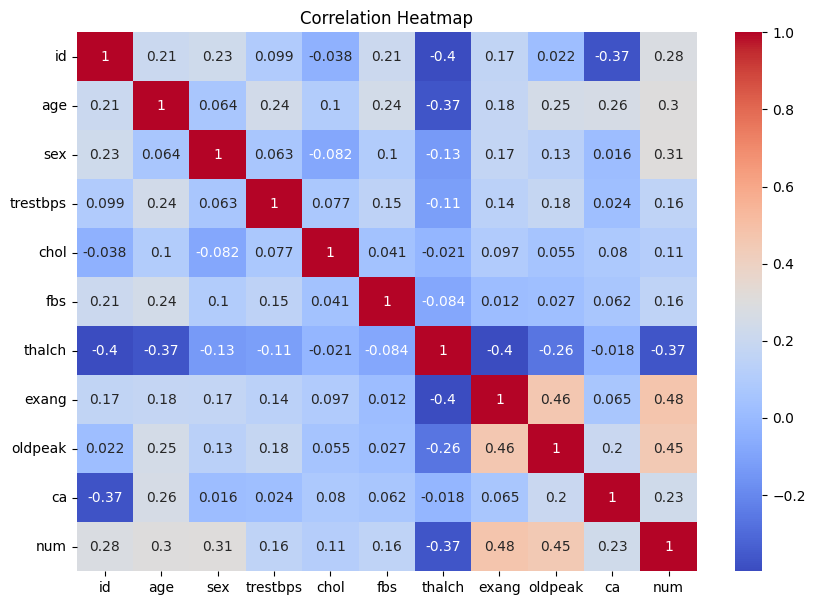

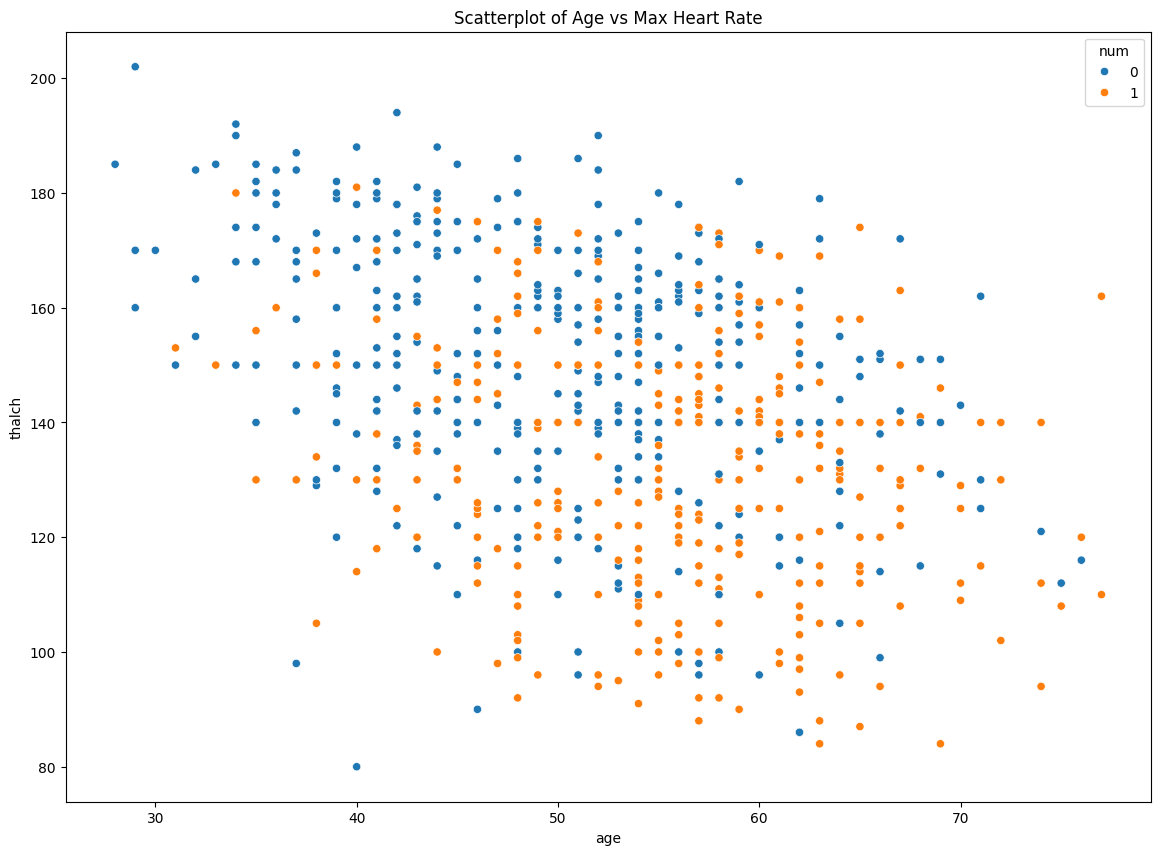

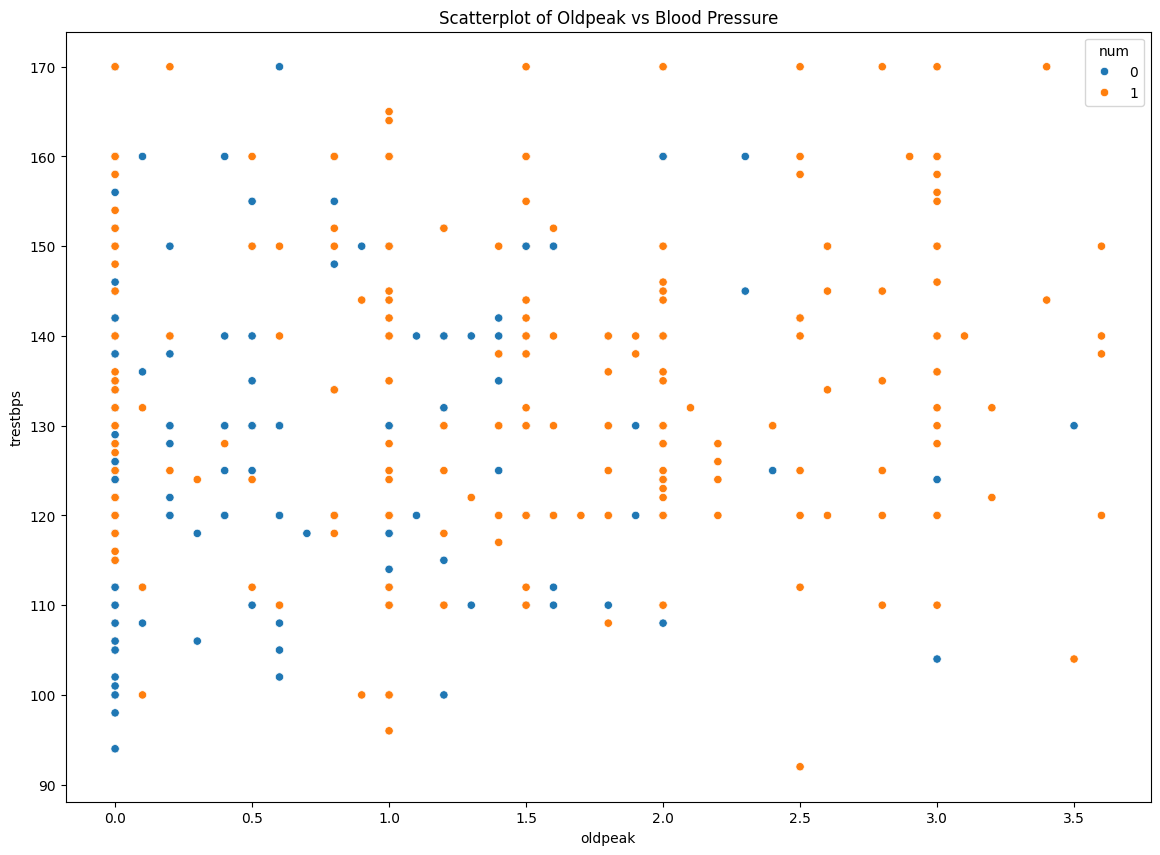

In [11]:
# EDA (Explorative Data Analysis)
#Histogram for Numerical cols
import matplotlib.pyplot as plt
import seaborn as sns
num_cols=['age','trestbps','chol','thalch','oldpeak']
plt.figure(figsize=(14,10))
for i,col in enumerate(num_cols, 1):
  plt.subplot(3,2,i)
  sns.histplot(df[col],kde=True,bins=30)
  plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

#Boxplot for Outliers
plt.figure(figsize=(14,10))
for i,col in enumerate(num_cols, 1):
  plt.subplot(3,2,1)
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

#countplots for categorical
cat_cols=['sex','cp','restecg','slope','thal','dataset']
plt.figure(figsize=(16,12))
for i,col,in enumerate(cat_cols,1):
  plt.subplot(3,2,i)
  sns.countplot(x=df[col])
  plt.title(f'Countplot of {col}')
plt.tight_layout()
plt.show()

#correlation Heatmap relation between numerical and target
plt.figure(figsize=(10,7))
sns.heatmap(df.select_dtypes(include=np.number).corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Scatterplots relationship Visualization
plt.figure(figsize=(14,10))
sns.scatterplot(x=df['age'],y=df['thalch'],hue=df['num'])
plt.title('Scatterplot of Age vs Max Heart Rate')
plt.show()

plt.figure(figsize=(14,10))
sns.scatterplot(x=df['oldpeak'],y=df['trestbps'],hue=df['num'])
plt.title('Scatterplot of Oldpeak vs Blood Pressure')
plt.show()

In [12]:
#Feature Engineering
df=df.drop(columns=['id'])

In [13]:
num_fetures=['age','trestbps','chol','thalch','oldpeak','ca']
cat_features=['sex','cp','restecg','slope','thal','dataset','exang','fbs']
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

numerical_transformer=StandardScaler()
categorical_transformer=OneHotEncoder(handle_unknown='ignore')

preprocessor=ColumnTransformer(
    transformers=[
        ('num',numerical_transformer,num_fetures),
        ('cat',categorical_transformer,cat_features)
    ]
)

df['hrr']=220-df['age']-df['thalch']
num_fetures.append('hrr')

In [14]:
# Model Training
X=df.drop(columns=['num'])
y=df['num']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print("Train shape:",X_train.shape,"Test Shape:",X_test.shape)
print("Train distribution:\n",y_train.value_counts())

Train shape: (561, 15) Test Shape: (141, 15)
Train distribution:
 num
0    302
1    259
Name: count, dtype: int64


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
lr=Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',LogisticRegression(max_iter=1000,random_state=42))
])
rf=Pipeline([
    ('preprocessor',preprocessor),
    ('classifier',RandomForestClassifier(n_estimators=100,random_state=42))
])
lr.fit(X_train,y_train)
rf.fit(X_train,y_train)
print("Models Trained")

Models Trained


In [16]:
#Evaluation
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report, RocCurveDisplay
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(pipe, X_test, y_test, plot_roc=False):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", cm)
    if roc is not None:
        print("ROC AUC:", roc)
    if plot_roc and y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.show()
    return {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1, 'roc_auc':roc}

print("LOGISTIC")
res_lr = evaluate_model(lr, X_test, y_test, plot_roc=False)
print("\nRANDOM FOREST")
res_rf = evaluate_model(rf, X_test, y_test, plot_roc=False)

results_df = pd.DataFrame([res_lr, res_rf], index=['LogisticRegression','RandomForest'])
print(results_df)


LOGISTIC
              precision    recall  f1-score   support

           0       0.78      0.79      0.78        76
           1       0.75      0.74      0.74        65

    accuracy                           0.77       141
   macro avg       0.76      0.76      0.76       141
weighted avg       0.77      0.77      0.77       141

Confusion matrix:
 [[60 16]
 [17 48]]
ROC AUC: 0.834412955465587

RANDOM FOREST
              precision    recall  f1-score   support

           0       0.77      0.78      0.77        76
           1       0.73      0.72      0.73        65

    accuracy                           0.75       141
   macro avg       0.75      0.75      0.75       141
weighted avg       0.75      0.75      0.75       141

Confusion matrix:
 [[59 17]
 [18 47]]
ROC AUC: 0.83917004048583
                    accuracy  precision    recall        f1   roc_auc
LogisticRegression  0.765957   0.750000  0.738462  0.744186  0.834413
RandomForest        0.751773   0.734375  0.723077  0.

In [18]:
import joblib
import os

# Create the 'models' directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(lr,"models/heart_disease_lr.pkl")
print("Model saved: models/heart_disease_lr.pkl")

Model saved: models/heart_disease_lr.pkl
